# 📊 Exploratory Data Analysis — GoEmotions Dataset
## PetPal Emotion Classifier

This notebook explores the GoEmotions dataset **before training**, covering:
1. Dataset shape & structure
2. Original 27-label distribution
3. Mapped 7-class (UI emotion) distribution
4. Text length analysis
5. Label co-occurrence (multi-label analysis)
6. Word clouds per emotion
7. Class imbalance observations

---
## 1. Setup & Load Data

In [24]:
# Uncomment if needed
# !pip install pandas matplotlib seaborn wordcloud

In [25]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams["figure.dpi"] = 120

print("Imports ready ✅")

Imports ready ✅


In [26]:
# Load the GoEmotions CSVs
DATA_DIR = "./data/raw"

parts = sorted(glob.glob(os.path.join(DATA_DIR, "goemotions_*.csv")))
if parts:
    df = pd.concat([pd.read_csv(p) for p in parts], ignore_index=True)
    print(f"Loaded {len(parts)} CSV files")
else:
    df = pd.read_csv(os.path.join(DATA_DIR, "goemotions.csv"))
    print("Loaded single CSV file")

print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
df.head()

Loaded 3 CSV files
Total rows: 211,225
Total columns: 37


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,...,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,...,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,...,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,...,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,...,0,0,0,0,0,0,0,0,0,1


In [27]:
# Identify emotion columns vs metadata columns
GOEMOTIONS_LABELS = [
    "admiration", "amusement", "anger", "annoyance", "approval",
    "caring", "confusion", "curiosity", "desire", "disappointment",
    "disapproval", "disgust", "embarrassment", "excitement", "fear",
    "gratitude", "grief", "joy", "love", "nervousness",
    "optimism", "pride", "realization", "relief", "remorse",
    "sadness", "surprise", "neutral",
]

# Columns present in dataset
emotion_cols = [c for c in GOEMOTIONS_LABELS if c in df.columns]
meta_cols = [c for c in df.columns if c not in emotion_cols]

print(f"Emotion columns found: {len(emotion_cols)}")
print(f"Metadata columns: {meta_cols}")

Emotion columns found: 28
Metadata columns: ['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id', 'created_utc', 'rater_id', 'example_very_unclear']


---
## 2. Basic Dataset Statistics

In [28]:
print("📋 Dataset Info:")
print(f"   Shape:           {df.shape}")
print(f"   Missing values:  {df['text'].isna().sum()}")
print(f"   Duplicate texts: {df['text'].duplicated().sum()}")
print(f"\n📊 Emotion columns summary (Mean & Total Samples):")
df[emotion_cols].agg(['mean', 'sum']).T

📋 Dataset Info:
   Shape:           (211225, 37)
   Missing values:  0
   Duplicate texts: 153493

📊 Emotion columns summary (Mean & Total Samples):


,mean,sum
admiration,0.081103,17131.0
amusement,0.043768,9245.0
anger,0.038272,8084.0
annoyance,0.064472,13618.0
approval,0.083418,17620.0
caring,0.028401,5999.0
confusion,0.034840,7359.0
curiosity,0.045885,9692.0
desire,0.018071,3817.0
disappointment,0.040095,8469.0


In [29]:
# How many labels per row?
df["num_labels"] = df[emotion_cols].sum(axis=1)

print("📊 Labels per row:")
print(df["num_labels"].value_counts().sort_index())
print(f"\nAverage labels per row: {df['num_labels'].mean():.2f}")
print(f"Rows with 0 labels:    {(df['num_labels'] == 0).sum():,}")
print(f"Rows with 1 label:     {(df['num_labels'] == 1).sum():,}")
print(f"Rows with 2+ labels:   {(df['num_labels'] >= 2).sum():,}")

📊 Labels per row:
num_labels
0       3411
1     171820
2      31187
3       4218
4        399
5        106
6         53
7         20
8          6
9          3
10         1
12         1
Name: count, dtype: int64

Average labels per row: 1.18
Rows with 0 labels:    3,411
Rows with 1 label:     171,820
Rows with 2+ labels:   35,994


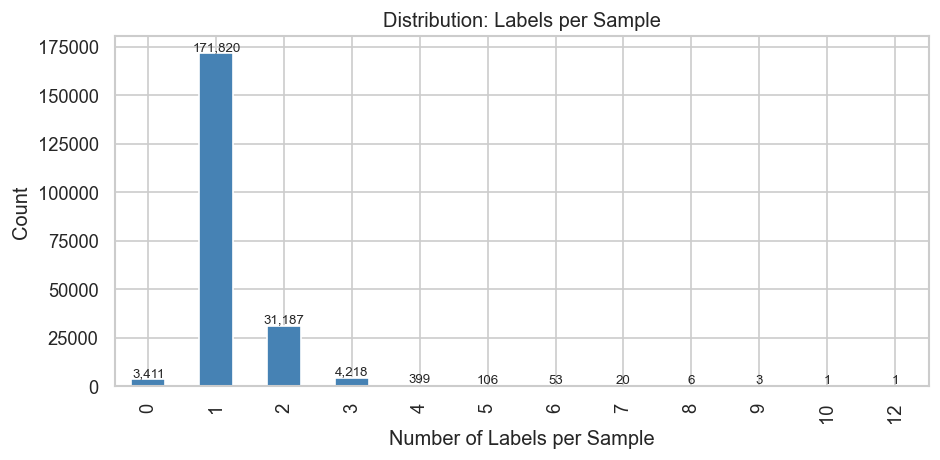

In [30]:
# Bar chart: labels per row
fig, ax = plt.subplots(figsize=(8, 4))
df["num_labels"].value_counts().sort_index().plot(kind="bar", color="steelblue", ax=ax)
ax.set_xlabel("Number of Labels per Sample")
ax.set_ylabel("Count")
ax.set_title("Distribution: Labels per Sample")
ax.bar_label(ax.containers[0], fmt="{:,.0f}", fontsize=8)
plt.tight_layout()
plt.show()

---
## 3. Original 27-Label Distribution

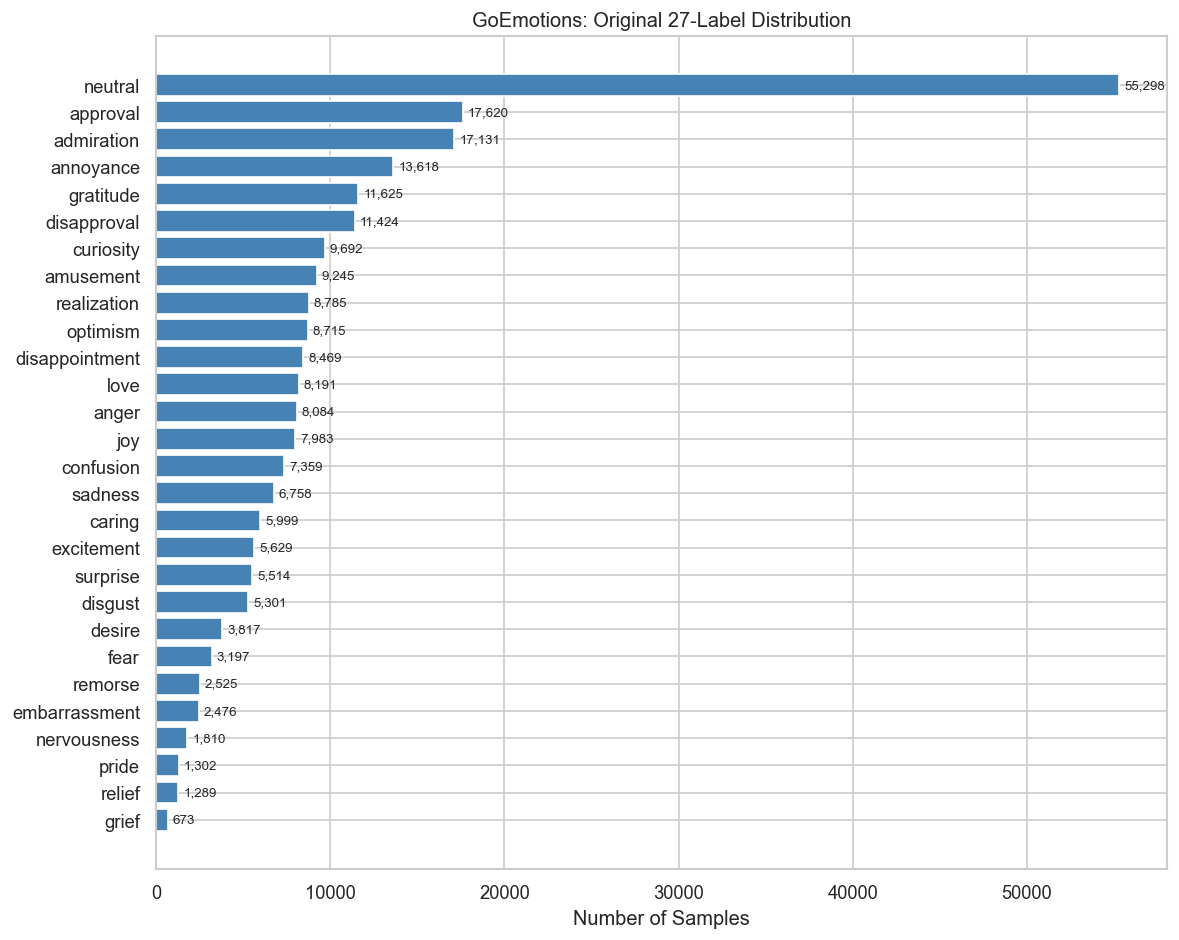


Most common:  neutral (55,298)
Least common: grief (673)
Imbalance ratio: 82.2x


In [31]:
# Count samples per original emotion
label_counts = df[emotion_cols].sum().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10, 8))
bars = ax.barh(label_counts.index, label_counts.values, color="steelblue")
ax.set_xlabel("Number of Samples")
ax.set_title("GoEmotions: Original 27-Label Distribution")
ax.bar_label(bars, fmt="{:,.0f}", fontsize=8, padding=3)
plt.tight_layout()
plt.show()

print(f"\nMost common:  {label_counts.index[-1]} ({label_counts.iloc[-1]:,})")
print(f"Least common: {label_counts.index[0]} ({label_counts.iloc[0]:,})")
print(f"Imbalance ratio: {label_counts.iloc[-1] / label_counts.iloc[0]:.1f}x")

---
## 4. Mapped 7-Class (UI Emotion) Distribution
This is what the model will actually train on.

In [32]:
# Our 27 → 7 mapping
LABEL_TO_UI = {
    "admiration": "happy",   "amusement": "happy",  "approval": "happy",
    "excitement": "happy",   "gratitude": "happy",  "joy": "happy",
    "love": "happy",         "optimism": "happy",   "pride": "happy",
    "relief": "happy",       "desire": "happy",
    "neutral": "calm",       "realization": "calm", "caring": "calm",
    "sadness": "sad",        "grief": "sad",        "disappointment": "sad",
    "remorse": "sad",
    "anger": "angry",        "annoyance": "angry",  "disgust": "angry",
    "disapproval": "angry",
    "fear": "anxious",       "nervousness": "anxious",
    "embarrassment": "stressed",
    "confusion": "confused", "curiosity": "confused", "surprise": "confused",
}

UI_LABEL_NAMES = ["happy", "calm", "sad", "angry", "anxious", "stressed", "confused"]
UI_COLORS = ["#FFD700", "#87CEEB", "#6495ED", "#FF6347", "#DDA0DD", "#FFA07A", "#98FB98"]

# Map each row to a UI emotion (pick first active label)
def get_ui_emotion(row):
    for label in GOEMOTIONS_LABELS:
        if label in row.index and row[label] == 1:
            ui = LABEL_TO_UI.get(label)
            if ui is not None:
                return ui
    return None

df["ui_emotion"] = df.apply(get_ui_emotion, axis=1)

mapped_count = df["ui_emotion"].notna().sum()
dropped_count = df["ui_emotion"].isna().sum()
print(f"Mapped:  {mapped_count:,}")
print(f"Dropped: {dropped_count:,} (no label or unmapped)")

Mapped:  207,814
Dropped: 3,411 (no label or unmapped)


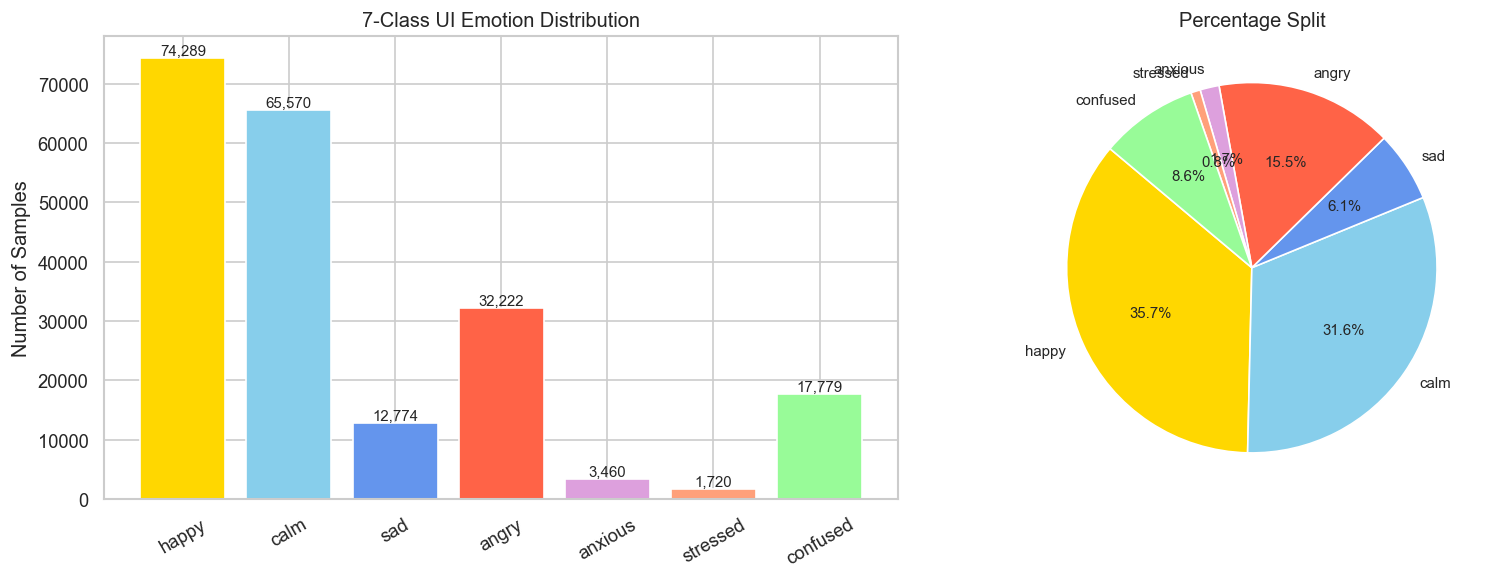


📊 7-Class Summary:
   0 = happy      →  74,289 samples  (35.7%)
   1 = calm       →  65,570 samples  (31.6%)
   2 = sad        →  12,774 samples  (6.1%)
   3 = angry      →  32,222 samples  (15.5%)
   4 = anxious    →   3,460 samples  (1.7%)
   5 = stressed   →   1,720 samples  (0.8%)
   6 = confused   →  17,779 samples  (8.6%)


In [33]:
# 7-class distribution
ui_counts = df["ui_emotion"].value_counts().reindex(UI_LABEL_NAMES)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
bars = axes[0].bar(ui_counts.index, ui_counts.values, color=UI_COLORS)
axes[0].set_ylabel("Number of Samples")
axes[0].set_title("7-Class UI Emotion Distribution")
axes[0].bar_label(bars, fmt="{:,.0f}", fontsize=9)
axes[0].tick_params(axis='x', rotation=30)

# Pie chart
axes[1].pie(
    ui_counts.values, labels=ui_counts.index, autopct="%1.1f%%",
    colors=UI_COLORS, startangle=140, textprops={'fontsize': 9}
)
axes[1].set_title("Percentage Split")

plt.tight_layout()
plt.show()

# Summary table
print("\n📊 7-Class Summary:")
for i, name in enumerate(UI_LABEL_NAMES):
    count = ui_counts[name]
    pct = count / ui_counts.sum() * 100
    print(f"   {i} = {name:10s} → {count:>7,} samples  ({pct:.1f}%)")

---
## 5. Text Length Analysis

In [34]:
# Text length in characters and words
df["text_len_chars"] = df["text"].astype(str).str.len()
df["text_len_words"] = df["text"].astype(str).str.split().str.len()

print("📏 Text Length Statistics:")
print(f"   Characters — Mean: {df['text_len_chars'].mean():.0f}, "
      f"Median: {df['text_len_chars'].median():.0f}, "
      f"Max: {df['text_len_chars'].max():,}")
print(f"   Words      — Mean: {df['text_len_words'].mean():.0f}, "
      f"Median: {df['text_len_words'].median():.0f}, "
      f"Max: {df['text_len_words'].max():,}")

📏 Text Length Statistics:
   Characters — Mean: 69, Median: 67, Max: 703
   Words      — Mean: 13, Median: 13, Max: 33


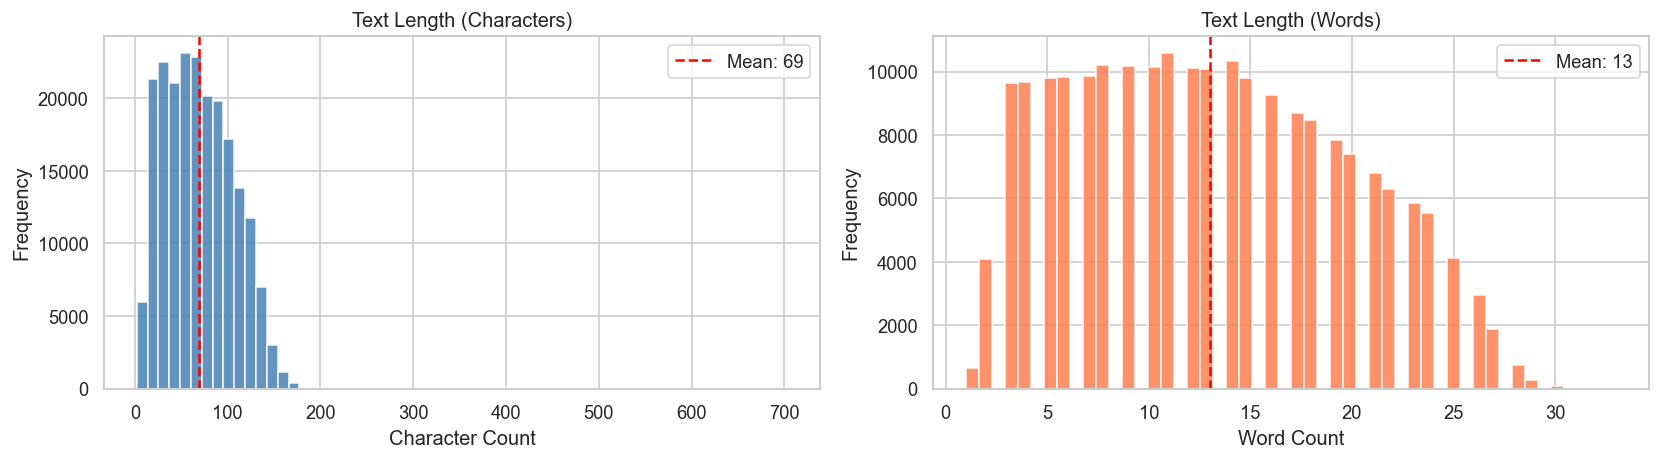

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Character length distribution
axes[0].hist(df["text_len_chars"], bins=60, color="steelblue", edgecolor="white", alpha=0.85)
axes[0].axvline(df["text_len_chars"].mean(), color="red", linestyle="--", label=f"Mean: {df['text_len_chars'].mean():.0f}")
axes[0].set_xlabel("Character Count")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Text Length (Characters)")
axes[0].legend()

# Word count distribution
axes[1].hist(df["text_len_words"], bins=50, color="coral", edgecolor="white", alpha=0.85)
axes[1].axvline(df["text_len_words"].mean(), color="red", linestyle="--", label=f"Mean: {df['text_len_words'].mean():.0f}")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Text Length (Words)")
axes[1].legend()

plt.tight_layout()
plt.show()

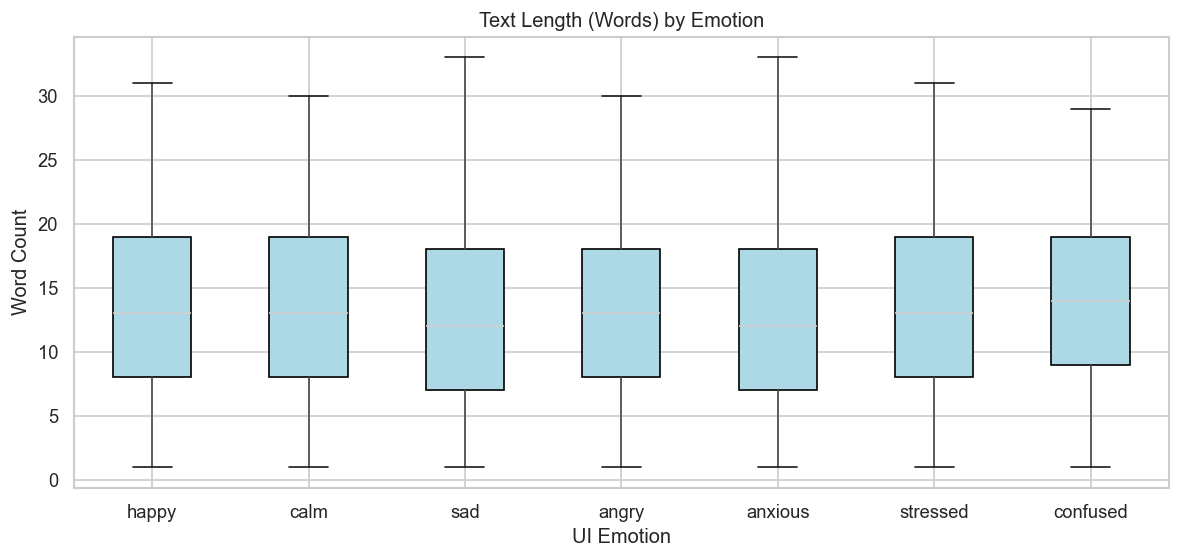

In [36]:
# Text length per UI emotion (box plot)
df_mapped = df[df["ui_emotion"].notna()].copy()

fig, ax = plt.subplots(figsize=(10, 5))
df_mapped.boxplot(column="text_len_words", by="ui_emotion", ax=ax,
                   positions=range(len(UI_LABEL_NAMES)),
                   patch_artist=True,
                   boxprops=dict(facecolor="lightblue"))
ax.set_xticklabels(UI_LABEL_NAMES)
ax.set_xlabel("UI Emotion")
ax.set_ylabel("Word Count")
ax.set_title("Text Length (Words) by Emotion")
plt.suptitle("")  # Remove default title from boxplot
plt.tight_layout()
plt.show()

---
## 6. Label Co-occurrence (Multi-label Heatmap)
Shows how often two emotions appear together in the same sample.

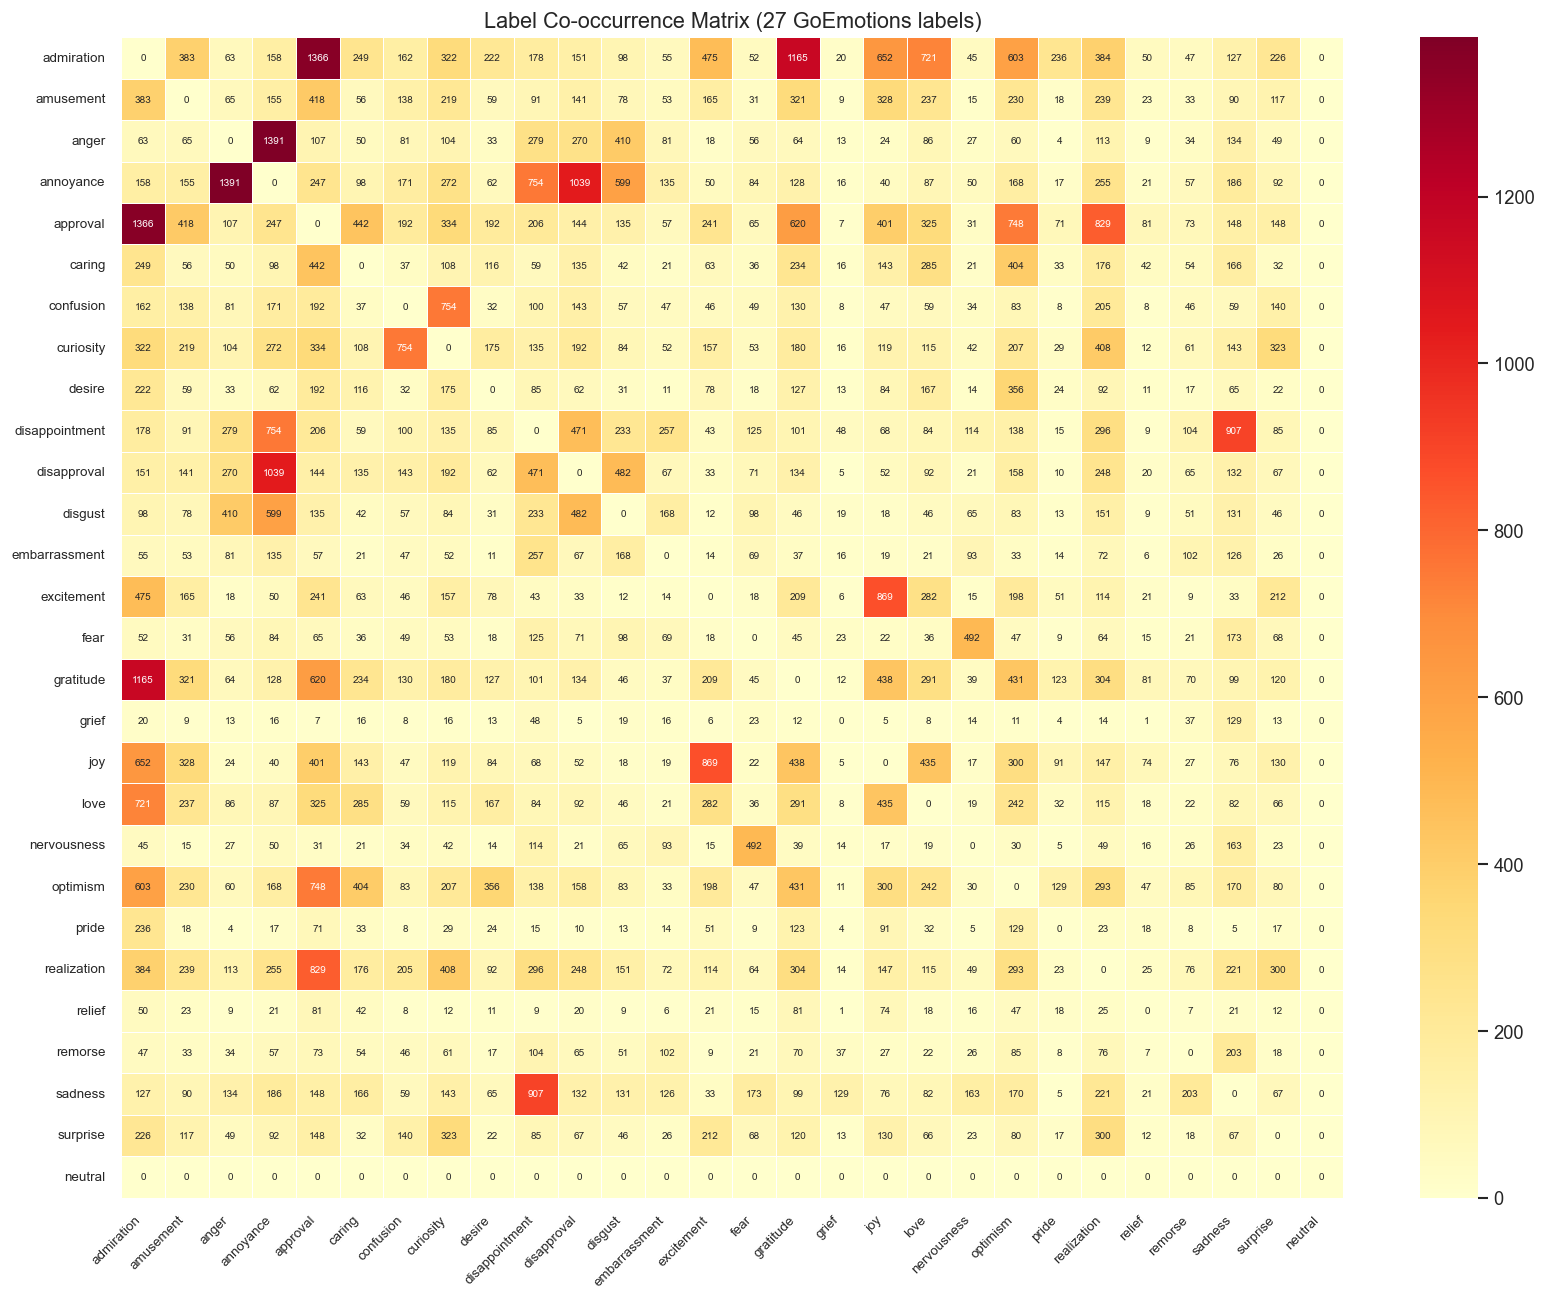

In [37]:
# Co-occurrence matrix
cooccurrence = df[emotion_cols].T.dot(df[emotion_cols])

# Normalize by diagonal (self-count) for better readability
# FORCE A MUTABLE COPY TO AVOID READ-ONLY ARRAY ISSUES
mutable_arr = cooccurrence.to_numpy(copy=True)
np.fill_diagonal(mutable_arr, 0)
cooc_plot = pd.DataFrame(mutable_arr, index=cooccurrence.index, columns=cooccurrence.columns)

fig, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(
    cooc_plot,
    cmap="YlOrRd",
    annot=True,
    fmt="d",
    linewidths=0.3,
    ax=ax,
    annot_kws={"fontsize": 6},
)
ax.set_title("Label Co-occurrence Matrix (27 GoEmotions labels)", fontsize=13)
plt.xticks(rotation=45, ha="right", fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [38]:
# Top 15 most common label pairs
pairs = []
for i, l1 in enumerate(emotion_cols):
    for j, l2 in enumerate(emotion_cols):
        if i < j:
            count = ((df[l1] == 1) & (df[l2] == 1)).sum()
            if count > 0:
                pairs.append((l1, l2, count))

pairs_df = pd.DataFrame(pairs, columns=["Label 1", "Label 2", "Count"])
pairs_df = pairs_df.sort_values("Count", ascending=False).head(15).reset_index(drop=True)

print("🔗 Top 15 Label Pairs (co-occurring in same sample):")
pairs_df

🔗 Top 15 Label Pairs (co-occurring in same sample):


,Label 1,Label 2,Count
0,anger,annoyance,1391
1,admiration,approval,1366
2,admiration,gratitude,1165
3,annoyance,disapproval,1039
4,disappointment,sadness,907
5,excitement,joy,869
6,approval,realization,829
7,annoyance,disappointment,754
8,confusion,curiosity,754
9,approval,optimism,748


---
## 7. Sample Texts per Emotion
Let's look at a few example texts for each of our 7 UI emotions.

In [39]:
print("📝 Sample texts per UI emotion:\n")
for emotion in UI_LABEL_NAMES:
    subset = df_mapped[df_mapped["ui_emotion"] == emotion]
    print(f"\n{'='*60}")
    print(f"  {emotion.upper()} ({len(subset):,} samples)")
    print(f"{'='*60}")
    samples = subset["text"].sample(n=min(3, len(subset)), random_state=42)
    for i, text in enumerate(samples, 1):
        print(f"  {i}. {text[:120]}")

📝 Sample texts per UI emotion:


  HAPPY (74,289 samples)
  1. I never get sick of seeing me and my dad go absolutely fucking wild in that video
  2. so true lmao
  3. A girl has grown up a lot since she was a 12 year old on the show, and she's grown up to be so beautiful as well.

  CALM (65,570 samples)
  1. First- damn what a block Secondly- that was a really smart timeout there. Expected a prayer shot.
  2. Ohhhhh yeah.
  3. Every. Bloody. Time. I never learn to just shut up though.

  SAD (12,774 samples)
  1. I don't see any shoes on his feet after he lands. Kid is fucking dead.
  2. She has major SB😖
  3. I’m so sorry 🤪

  ANGRY (32,222 samples)
  1. Daily Wire is a hate site, and [NAME] is a bigot.
  2. Don't you fucken do it
  3. this, they will find a way. we screwed over my entire street for an hour when I got my new fridge..

  ANXIOUS (3,460 samples)
  1. I’m more worried about the dude getting pissed all over my shoes
  2. I’m more worried about the dude getting pissed al

---
## 8. Key Observations & Insights
Run this cell to print a summary of the EDA findings.

In [40]:
print("\n" + "=" * 60)
print("  📊  EDA SUMMARY — Key Observations")
print("=" * 60)

total = len(df)
print(f"\n1. DATASET SIZE: {total:,} samples")

multi = (df["num_labels"] >= 2).sum()
print(f"\n2. MULTI-LABEL: {multi:,} samples ({multi/total*100:.1f}%) have 2+ labels")
print(f"   → We pick the FIRST active label → single-label classification")

print(f"\n3. CLASS IMBALANCE (7-class):")
biggest = ui_counts.idxmax()
smallest = ui_counts.idxmin()
ratio = ui_counts.max() / ui_counts.min()
print(f"   Largest:  {biggest} ({ui_counts.max():,})")
print(f"   Smallest: {smallest} ({ui_counts.min():,})")
print(f"   Imbalance ratio: {ratio:.1f}x")
print(f"   → 'happy' dominates, 'stressed' & 'anxious' are minority classes")

print(f"\n4. TEXT LENGTH:")
print(f"   Mean: {df['text_len_words'].mean():.0f} words | Max: {df['text_len_words'].max()}")
print(f"   → MAX_SEQ_LEN=128 tokens should cover most samples")

print(f"\n5. NEUTRAL LABEL:")
neutral_count = df['neutral'].sum() if 'neutral' in df.columns else 0
print(f"   {neutral_count:,} samples are 'neutral' → mapped to 'calm'")
print(f"   → This is a large chunk of the 'calm' class")

print("\n" + "=" * 60)
print("  ✅  EDA Complete — Ready for Training!")
print("=" * 60)


  📊  EDA SUMMARY — Key Observations

1. DATASET SIZE: 211,225 samples

2. MULTI-LABEL: 35,994 samples (17.0%) have 2+ labels
   → We pick the FIRST active label → single-label classification

3. CLASS IMBALANCE (7-class):
   Largest:  happy (74,289)
   Smallest: stressed (1,720)
   Imbalance ratio: 43.2x
   → 'happy' dominates, 'stressed' & 'anxious' are minority classes

4. TEXT LENGTH:
   Mean: 13 words | Max: 33
   → MAX_SEQ_LEN=128 tokens should cover most samples

5. NEUTRAL LABEL:
   55,298 samples are 'neutral' → mapped to 'calm'
   → This is a large chunk of the 'calm' class

  ✅  EDA Complete — Ready for Training!
